In [24]:
import numpy as np
import matplotlib.pyplot as plt
from skimage import io, color
import os
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, classification_report

In [2]:
# Function to load images from directory
def load_images_from_folder(folder, is_gray = True):
    images = []
    for filename in os.listdir(folder):
        img = io.imread(os.path.join(folder,filename)).astype(np.uint8)
        if img is not None:
            img = img/255
            if is_gray:
                images.append(color.rgb2gray(img))
            else:    
                images.append(img)
    return images


In [3]:
# Load images from folders A and B
folder_A = 'trainval/A'
folder_B = 'trainval/B'
folder_label = 'trainval/label'

In [4]:
images_A = load_images_from_folder(folder_A)


In [5]:
images_A = np.array(images_A)

In [6]:
print(images_A[40].shape)

(256, 256)


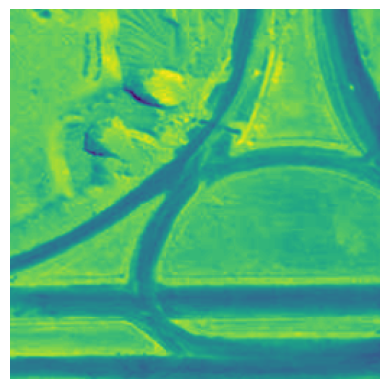

In [7]:
plt.imshow(images_A[40])
plt.axis('off')  
plt.show()

In [8]:
images_B = load_images_from_folder(folder_B)


In [9]:
images_B = np.array(images_B)

In [10]:
labels = load_images_from_folder(folder_label, is_gray = False)

In [11]:
labels = np.array(labels)

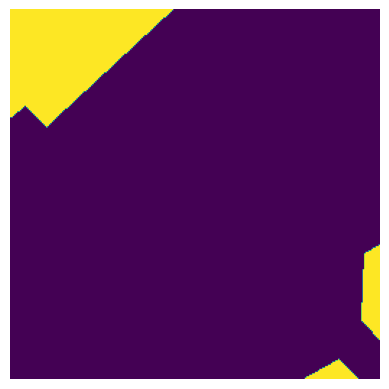

[[1. 1. 1. ... 0. 0. 0.]
 [1. 1. 1. ... 0. 0. 0.]
 [1. 1. 1. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]


In [12]:
plt.imshow(labels[870])
plt.axis('off')  
plt.show()

print(labels[870])

In [13]:

def calculate_jaccard_index(pred_mask, true_mask):
    intersection = np.logical_and(pred_mask, true_mask).sum()
    union = np.logical_or(pred_mask, true_mask).sum()
    jaccard_index = intersection / union
    return jaccard_index

def calculate_jaccard_index_avg(pred_mask, true_mask):
    arr = []
    for i in range(len(pred_mask)):
        intersection = np.logical_and(pred_mask[i], true_mask[i]).sum()
        union = np.logical_or(pred_mask[i], true_mask[i]).sum()
        if union != 0:
            arr.append(intersection / union)
        else:
            arr.append(1)
    
    jaccard_index = np.array(arr).mean()        
    return jaccard_index

In [14]:
def change_detection_cva(images_time1, images_time2):
    if images_time1.shape != images_time2.shape:
        raise ValueError("Input arrays must have the same shape")

    change_images = np.zeros_like(images_time1, dtype=np.uint8)

    change_vectors = np.abs(images_time2 - images_time1)


    for i in range(images_time1.shape[0]):
        for j in range(images_time1.shape[1]):
            magnitude = np.linalg.norm(change_vectors[i, j])
            change_images[i, j] = magnitude
            
           

    return change_images

In [15]:
cva_mask = change_detection_cva(images_A, images_B)

In [16]:
cva_mask_thresholded = cva_mask > 2

In [17]:
jaccard_index = calculate_jaccard_index(cva_mask_thresholded, labels)
jaccard_index_avg = calculate_jaccard_index_avg(cva_mask_thresholded, labels)
print("For CVA Jaccard Index:", jaccard_index)
print("For CVA Jaccard Index Avg:", jaccard_index_avg)

For CVA Jaccard Index: 0.18301865313962745
For CVA Jaccard Index Avg: 0.5690975386955706


In [18]:
def image_difference(image_A, image_B):
    diff = np.abs(image_A - image_B)
    return diff

In [19]:
change_mask = image_difference(images_A, images_B)

In [25]:
thresholds = [0.05,0.1,0.15,0.2,0.25,0.3,0.35,0.4,0.45,0.5]

for th in thresholds:
    change_mask_thresholded = change_mask > th
    jaccard_index = calculate_jaccard_index(change_mask_thresholded, labels)
    jaccard_index_avg = calculate_jaccard_index_avg(change_mask_thresholded, labels)
    print(f"Threshold:{th} | Our jaccard:{jaccard_index} | Avg jaccard:{jaccard_index_avg}")
    print(confusion_matrix(labels, change_mask_thresholded))
    print("===========================================================================================================")

Threshold:0.05 | Our jaccard:0.0960272052697665 | Avg jaccard:0.06715897795110276


ValueError: unknown is not supported

In [20]:
change_mask_thresholded = change_mask > 0.2

In [21]:
jaccard_index = calculate_jaccard_index(change_mask_thresholded, labels)
jaccard_index_avg = calculate_jaccard_index_avg(change_mask_thresholded, labels)
print("For Diff Jaccard Index:", jaccard_index)
print("For Diff Jaccard Index Avg:", jaccard_index_avg)

For Diff Jaccard Index: 0.13710098837362628
For Diff Jaccard Index Avg: 0.05627842701603991


In [22]:
def image_ratioing(images_A, images_B):
    epsilon = 1e-8
    ratio = (images_A + epsilon) / (images_B + epsilon)
    
    return ratio

In [23]:
ratio_mask = image_ratioing(images_A, images_B)

MemoryError: Unable to allocate 2.38 GiB for an array with shape (4868, 256, 256) and data type float64

In [39]:
ratio_mask_thresholded = np.logical_or(ratio_mask > 1 + 0.2, ratio_mask < 1 - 0.2)

In [40]:
jaccard_index = calculate_jaccard_index(ratio_mask_thresholded, labels)
print("For Ratio Jaccard Index:", jaccard_index)

For Ratio Jaccard Index: 0.12635443712328637


In [41]:
votes = ratio_mask_thresholded * 1 + change_mask_thresholded * 1 + cva_mask_thresholded * 1

In [42]:
print(votes)

[[[2 3 3 ... 3 3 3]
  [2 2 3 ... 3 3 3]
  [2 3 3 ... 3 3 3]
  ...
  [3 3 3 ... 3 3 3]
  [3 3 3 ... 3 3 3]
  [3 3 3 ... 3 2 3]]

 [[2 3 3 ... 3 3 3]
  [1 3 3 ... 3 3 3]
  [1 3 3 ... 3 3 3]
  ...
  [3 3 3 ... 3 3 3]
  [2 3 3 ... 3 3 3]
  [3 3 3 ... 3 3 3]]

 [[3 3 3 ... 2 3 3]
  [3 3 3 ... 1 3 3]
  [3 3 3 ... 1 2 3]
  ...
  [3 3 3 ... 3 3 3]
  [3 3 3 ... 3 3 3]
  [3 3 3 ... 3 3 3]]

 ...

 [[2 2 2 ... 0 0 0]
  [2 2 2 ... 0 0 0]
  [2 2 2 ... 0 0 0]
  ...
  [2 0 0 ... 0 0 0]
  [2 0 0 ... 0 0 0]
  [2 0 0 ... 0 0 0]]

 [[0 0 0 ... 0 0 0]
  [0 0 0 ... 0 0 0]
  [0 0 0 ... 0 0 0]
  ...
  [3 3 3 ... 1 1 1]
  [3 3 3 ... 1 1 1]
  [3 3 3 ... 1 1 1]]

 [[3 3 3 ... 2 2 2]
  [3 3 3 ... 2 2 2]
  [3 3 3 ... 2 1 1]
  ...
  [1 1 1 ... 3 3 3]
  [1 1 1 ... 3 3 3]
  [1 1 1 ... 3 3 3]]]


In [43]:
voted_images = votes >= 2

In [44]:
jaccard_index = calculate_jaccard_index(voted_images, labels)
print("For Voting Jaccard Index:", jaccard_index)

For Voting Jaccard Index: 0.14335765773646858


In [ ]:
# def image_add(image_A, image_B):
#     add = image_A + image_B
    
#     return add

In [ ]:
# add_mask = image_add(images_A, images_B)

In [ ]:
# ratio_mask = image_ratioing(change_mask, add_mask)

In [ ]:
# print(ratio_mask[0])

[[0.16896126 0.20463557 0.30228648 ... 0.22616186 0.22125225 0.19014694]
 [0.13138847 0.20383067 0.27535348 ... 0.22674713 0.22895976 0.20464347]
 [0.18145892 0.27287117 0.29429708 ... 0.21719255 0.22637899 0.22529378]
 ...
 [0.2459061  0.25100459 0.32658996 ... 0.19905648 0.19778442 0.20211926]
 [0.24481122 0.25063888 0.32840446 ... 0.18230673 0.20016583 0.19993947]
 [0.24203894 0.25234782 0.3225607  ... 0.1894931  0.1390279  0.17285591]]


In [ ]:
# thresholds = [0.05,0.1,0.15,0.2,0.25,0.3,0.35,0.4,0.45,0.5]

# for threshold in thresholds:
#     diff_thresholded = ratio_mask > threshold
#     jaccard_index = calculate_jaccard_index(diff_thresholded, labels)
#     print("For threshold:",threshold,"Jaccard Index:", jaccard_index)

For threshold: 0.05 Jaccard Index: 0.10966826991364918
For threshold: 0.1 Jaccard Index: 0.12887510710499217
For threshold: 0.15 Jaccard Index: 0.12951161235275704
For threshold: 0.2 Jaccard Index: 0.11561691391321353
For threshold: 0.25 Jaccard Index: 0.08143669125218865
For threshold: 0.3 Jaccard Index: 0.05552389050784794
For threshold: 0.35 Jaccard Index: 0.04103279674188023
For threshold: 0.4 Jaccard Index: 0.030847523603446177
For threshold: 0.45 Jaccard Index: 0.022683360983643944
For threshold: 0.5 Jaccard Index: 0.015962656561496737


In [ ]:
# ratio_mask_square = ratio_mask ** 2

In [ ]:
# ratio_mask_square[0]

array([[0.02854791, 0.04187572, 0.09137711, ..., 0.05114919, 0.04895256,
        0.03615586],
       [0.01726293, 0.04154694, 0.07581954, ..., 0.05141426, 0.05242257,
        0.04187895],
       [0.03292734, 0.07445868, 0.08661077, ..., 0.0471726 , 0.05124745,
        0.05075729],
       ...,
       [0.06046981, 0.0630033 , 0.106661  , ..., 0.03962348, 0.03911868,
        0.04085219],
       [0.05993253, 0.06281985, 0.10784949, ..., 0.03323574, 0.04006636,
        0.03997579],
       [0.05858285, 0.06367942, 0.1040454 , ..., 0.03590764, 0.01932876,
        0.02987917]])

In [ ]:
# thresholds = [0.001,0.002,0.003,0.004,0.005,0.006]

# for threshold in thresholds:
#     diff_thresholded = ratio_mask_square > threshold
#     jaccard_index = calculate_jaccard_index(diff_thresholded, labels)
#     print("For threshold:",threshold,"Jaccard Index:", jaccard_index)

For threshold: 0.001 Jaccard Index: 0.09510171659774246
For threshold: 0.002 Jaccard Index: 0.10591635013051266
For threshold: 0.003 Jaccard Index: 0.11276501100621432
For threshold: 0.004 Jaccard Index: 0.11748527249964094
For threshold: 0.005 Jaccard Index: 0.12090292199823698
For threshold: 0.006 Jaccard Index: 0.12344958894110053


In [ ]:
# thresholds = [0.05 , 0.1, 0.15 , 0.2 , 0.25, 0.3 , 0.35 , 0.4, 0.45, 0.5]


# change_mask = image_ratioing(images_A, images_B)

# for threshold in thresholds:
#     ratio_thresholded = np.logical_or(change_mask > 1 + threshold, change_mask < 1 - threshold)
#     jaccard_index = calculate_jaccard_index(ratio_thresholded, labels)
#     print("For threshold:",threshold,"Jaccard Index:", jaccard_index)

For threshold: 0.05 Jaccard Index: 0.08926409051781084
For threshold: 0.1 Jaccard Index: 0.10997686144945415
For threshold: 0.15 Jaccard Index: 0.12186506239680314
For threshold: 0.2 Jaccard Index: 0.12635443712328637
For threshold: 0.25 Jaccard Index: 0.1257333399936745
For threshold: 0.3 Jaccard Index: 0.12056959464848166
For threshold: 0.35 Jaccard Index: 0.10608245382178573
For threshold: 0.4 Jaccard Index: 0.08451538223011756
For threshold: 0.45 Jaccard Index: 0.06937602833932582
For threshold: 0.5 Jaccard Index: 0.06179149036717739
